Generate list of samples to use for QA checks for temporal consistency

In [1]:
%load_ext lab_black

In [2]:
from datetime import timedelta

from cloudpathlib import AnyPath
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
from shapely.geometry import Point

from cyano.data.utils import add_unique_identifier

In [3]:
STATES_SHAPEFILE = gpd.GeoDataFrame.from_file(
    "../../competition-nasa-cyanobacteria/data/raw/cb_2018_us_state_500k/cb_2018_us_state_500k.shp"
)


def plot_map(df, markersize=5, **kwargs):
    _, ax = plt.subplots()

    STATES_SHAPEFILE.plot(color="ghostwhite", edgecolor="lightgray", ax=ax)

    geometry = [Point(xy) for xy in zip(df.longitude, df.latitude)]
    gdf = gpd.GeoDataFrame(df, geometry=geometry)
    gdf.plot(ax=ax, markersize=markersize)

    ax.set_xlim([-125, -65])
    ax.set_ylim([25, 50])

    return ax

In [4]:
df = pd.read_csv(
    AnyPath(
        "s3://drivendata-competition-nasa-cyanobacteria/data/final/combined_final_release.csv"
    )
)
df["date"] = pd.to_datetime(df.date)
df.head(3)

,uid,data_provider,region,latitude,longitude,date,density_cells_per_ml,severity,distance_to_water_m
0,aabm,Indiana State Department of Health,midwest,39.080319,-86.430867,2018-05-14,585.0,1,0.0
1,aabn,California Environmental Data Exchange Network,west,36.559700,-121.510000,2016-08-31,5867500.0,4,3512.0
2,aacd,N.C. Division of Water Resources N.C. Departme...,south,35.875083,-78.878434,2020-11-19,290.0,1,514.0


### Select subset of samples

In [5]:
# subset to points in water bodies
subset = df[df.distance_to_water_m == 0]
print(f"{subset.shape[0]} samples in water")

# only have max 1 example at each location
subset = subset.sample(frac=1, random_state=3)
subset = subset.groupby(["latitude", "longitude"], as_index=False).first()
print(f"{subset.shape[0]} unique locations")

subset = subset.sample(n=5, random_state=3)
subset.head(1)

6722 samples in water
2320 unique locations


,latitude,longitude,uid,data_provider,region,date,density_cells_per_ml,severity,distance_to_water_m
863,37.824933,-99.916659,acpk,Bureau of Water Kansas Department of Health an...,midwest,2021-08-16,201641.0,3,0.0


In [6]:
subset.region.value_counts()

region
midwest      2
west         1
northeast    1
south        1
Name: count, dtype: int64

In [7]:
subset.severity.value_counts().sort_index()

severity
1    1
3    4
Name: count, dtype: int64

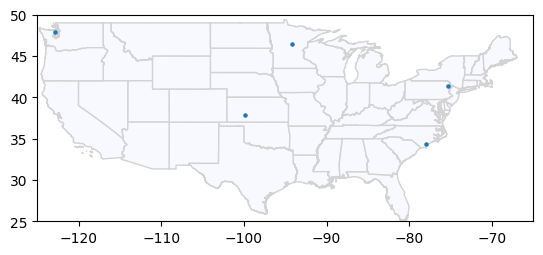

In [8]:
# see on a map where these samples are
plot_map(subset)
plt.show()

### Add temporal checks

In [9]:
predict_df = []

for sample in subset.itertuples():
    predict_df.append(
        pd.DataFrame(
            {
                "latitude": sample.latitude,
                "longitude": sample.longitude,
                # 4 week range for each sample
                # 7 days between samples
                "date": pd.date_range(
                    start=sample.date - timedelta(days=14),
                    end=sample.date + timedelta(days=14),
                    freq="7d",
                    inclusive="both",
                ),
            }
        )
    )

predict_df = pd.concat(predict_df)
predict_df.shape

(25, 3)

In [10]:
predict_df

,latitude,longitude,date
0,37.824933,-99.916659,2021-08-02
1,37.824933,-99.916659,2021-08-09
2,37.824933,-99.916659,2021-08-16
3,37.824933,-99.916659,2021-08-23
4,37.824933,-99.916659,2021-08-30
0,46.428900,-94.123490,2017-07-11
1,46.428900,-94.123490,2017-07-18
2,46.428900,-94.123490,2017-07-25
3,46.428900,-94.123490,2017-08-01
4,46.428900,-94.123490,2017-08-08


In [11]:
save_to = AnyPath(
    "s3://drivendata-competition-nasa-cyanobacteria/experiments/splits/temporal_check_samples.csv"
)

with save_to.open("w+") as f:
    predict_df.to_csv(f, index=False)

print(f"Samples for prediction saved to {save_to}")

Samples for prediction saved to s3://drivendata-competition-nasa-cyanobacteria/experiments/splits/temporal_check_samples.csv


In [12]:
from pathlib import Path

In [13]:
predict_df.to_csv("../temporal_check_samples.csv", index=False)

`python cyano/cli.py predict temporal_check_samples.csv --output-path temporal_check_preds.csv`